In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2426 sha256=e0a2c4fdf4317f35b6a127b26cc42fc12d5a1f9576f8cdfe5eb491d9f793e0ba
  Stored in directory: /root/.cache/pip/wheels/54/1d/51/d65a99106096dd07e3be6f08d5d3c2dd5f26ac98f626e5efc9
Successfully built colabgymrender


In [3]:
from colabgymrender.recorder import Recorder

  from scipy.ndimage.filters import sobel



#CartPole-v0

In [4]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  logger.warn(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



19.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t: 100%|██████████| 21/21 [00:00<00:00, 105.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1687616117.803995.mp4, 720000 bytes wanted but 0 bytes read,at frame 20/21, at time 0.67/0.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [5]:
total_reward

19.0

In [6]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            #nn.ReLU(),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [8]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [9]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [10]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

  states = torch.tensor(states, dtype=torch.float32)



Episode: 48 Step: 1000 Average reward: 20.541666666666668
Episode: 90 Step: 2000 Average reward: 22.0
Episode: 132 Step: 3000 Average reward: 23.02
Episode: 160 Step: 4000 Average reward: 27.23
Episode: 183 Step: 5000 Average reward: 31.3
Episode: 207 Step: 6000 Average reward: 35.63
Episode: 219 Step: 7000 Average reward: 42.89
Episode: 232 Step: 8000 Average reward: 49.48
Episode: 242 Step: 9000 Average reward: 55.93
Episode: 249 Step: 10000 Average reward: 62.66
Episode: 255 Step: 11000 Average reward: 69.56
Episode: 261 Step: 12000 Average reward: 78.86
Episode: 266 Step: 13000 Average reward: 86.5
Episode: 271 Step: 14000 Average reward: 94.85
Episode: 276 Step: 15000 Average reward: 102.81
Episode: 281 Step: 16000 Average reward: 111.35
Episode: 286 Step: 17000 Average reward: 118.32
Episode: 291 Step: 18000 Average reward: 126.97
Episode: 296 Step: 19000 Average reward: 134.72
Episode: 301 Step: 20000 Average reward: 142.25
Episode: 306 Step: 21000 Average reward: 150.38
Episode

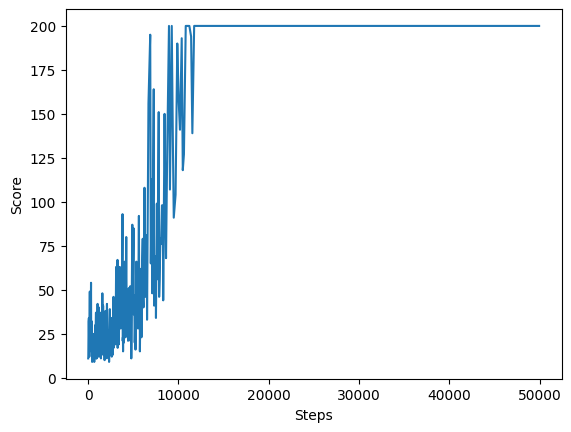

In [11]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [12]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


#MountainCar-v0

The following modifications have been made:

1. Neural Network Architecture:
 * Increased the number of units in the input layer from 16 to 24.
 * Increased the number of units in the first hidden layer from 24 to 48.
 * Reduced the number of units in the second hidden layer from 48 to 24.
 * Adapted the number of units in the output layer to match the number of actions in the environment.
2. Hyperparameters:
 * Adjusted the maximum and minimum exploration rates (epsilon).
 * Set the maximum number of training steps.
 * Defined the number of intervals for epsilon decay.
 * Tuned the discount factor (gamma) and learning rate (alpha ).

3. Replay Memory:
 * Set the maximum size of the replay memory.
 * Specified the minimum replay size required for training.
4. Training Batch:
 * Defined the batch size for sampling experiences from the replay memory.
5. Target Network Update:
 * Determined the frequency of updating the target network with Q network parameters.

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 24), # Increase the number of units in the input layer
            nn.Tanh(),
            nn.Linear(24, 48),  # Increase the number of units in the first hidden layer
            nn.Tanh(),
            nn.Linear(48, 24),  # Decrease the number of units in the second hidden layer
            nn.ReLU(),
            nn.Linear(24, env.action_space.n) # Adjust the number of units in the output layer based on the action space
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0))  # PyTorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()


In [31]:
# Hyperparameters for MountainCar-v0
max_epsilon = 1.0 #The maximum value of the exploration rate epsilon. It has been set to 1.0
min_epsilon = 0.01 #The minimum value of the exploration rate epsilon. It has been set to 0.01
max_num_steps = 50000 #The maximum number of steps in the training process. It has been set to 50,000
epsilon_decay_intervals = 1000 #The number of intervals over which the exploration rate epsilon decays from max_epsilon to min_epsilon.
gamma = 0.99  # discount
alpha = 0.001  # learning rate

memory_size = 200000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 100
env = gym.make('MountainCar-v0')


In [27]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -199.34285714285716
Episode: 40 Step: 8000 Average reward: -197.65
Episode: 45 Step: 9000 Average reward: -197.9111111111111
Episode: 50 Step: 10000 Average reward: -198.12
Episode: 55 Step: 11000 Average reward: -198.27272727272728
Episode: 60 Step: 12000 Average reward: -198.41666666666666
Episode: 65 Step: 13000 Average reward: -198.24615384615385
Episode: 70 Step: 14000 Average reward: -198.37142857142857
Episode: 75 Step: 15000 Average reward: -198.48
Episode: 80 Step: 16000 Average reward: -197.825
Episode: 86 Step: 17000 Average reward: -197.58139534883722
Episode: 91 Step: 18000 Average reward: -196.56043956043956
Episode: 97 Step: 19000 Average reward: -194.72164948453

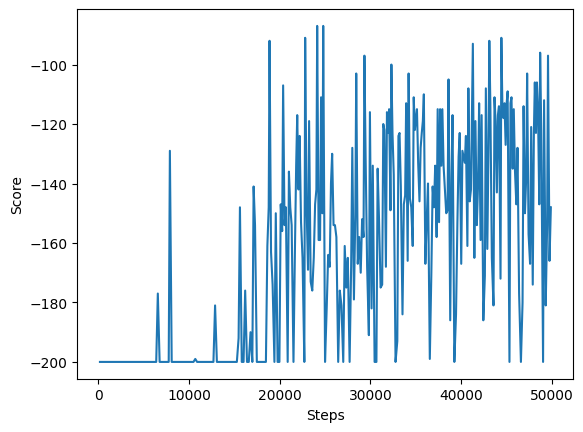

In [25]:
# Training model
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [26]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-95.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
